## map2loop: Topology fom Local file
This notebook reads in two layers from the local files:  geology polygons and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

In [1]:
import subprocess
import geopandas as gpd
import fiona 
import geoplot
import os
import osgeo 
from osgeo import ogr
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
from shapely.geometry import Polygon

newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
latmin=-23
latmax=-22
longmin=117
longmax=118

minx=500057+5000    #left hams
maxx=603028-5000    #right
miny=7455348+5000   #bottom
maxy=7567953-5000   #top
src_crs = 'epsg:4326'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

bbox=str(miny)+","+str(minx)+","+str(maxy)+","+str(maxx)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 

print(bbox)

7460348,505057,7562953,598028


## Plot geology polygons and bounding box

In [3]:
#os.environ

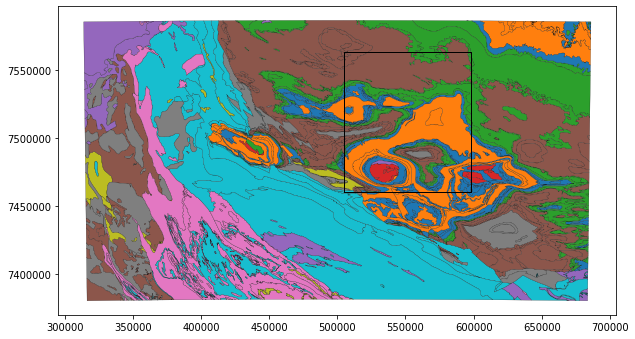

In [4]:
#geology=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology__DMIRS-014_&BBOX="+bbox+"&srs=EPSG:3857")
#geology=geology['geometry'].intersection(polygon)
#geology_ll = geology.to_crs('epsg:4326')
#print(geology.crs)
geology_ll = gpd.read_file("../test_data2/data/hams2_geol.shp")

base=geology_ll.plot(column='CODE',figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')
#print(wfs_geology.head())

## Save to file as WKT

In [6]:
sub_geol = geology_ll[['geometry', 'OBJECTID','CODE','GROUP_','UNITNAME','MIN_AGE_MA','MAX_AGE_MA','DESCRIPTN']]

f= open('../test_data2/tmp/T1_500k_geolx.csv',"w+")
f.write("WKT\tOBJECTID\tUNITNAME\tGROUP_\tMIN_AGE_MA\tMAX_AGE_MA\tCODE\tDESCRIPTN\n")
        
print(len(sub_geol)," polygons")
#print(sub_geol)
for i in range(0,len(sub_geol)):
    f.write("\""+str(sub_geol.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].OBJECTID)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].CODE)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].GROUP_)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].MIN_AGE_MA)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].MAX_AGE_MA)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].UNITNAME)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].DESCRIPTN)+"\"\n")
    
f.close()


961  polygons


## Read and save WAROX point data as WKT

207  points


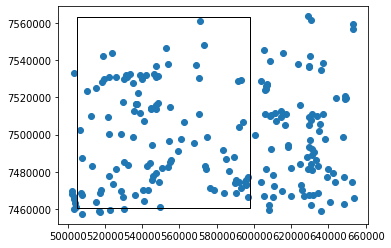

In [7]:
warox = gpd.read_file("../test_data2/data/hams2_structure.shp")


sub_pts = warox[['geometry', 'GEOPNT_ID','DIP','DIP_DIR']]

f= open('../test_data2/tmp/warox_wgs84x.csv',"w+")
f.write("WKT\tGEOPNT_ID\tDIP\tDIP_DIR\n")

print(len(sub_pts)," points")


#for i in range(0,len(sub_pts)):
#    for j in range(0,len(sub_geol)):
#        if(sub_pts.loc[i].geometry.within(sub_geol.loc[j].geometry)):
#            print(i,j)

for i in range(0,len(sub_pts)):
    line="\""+str(sub_pts.loc[i].geometry)+"\"\t\""+str(sub_pts.loc[i].GEOPNT_ID)+"\"\t\""+\
      str(sub_pts.loc[i].DIP)+"\"\t\""+str(sub_pts.loc[i].DIP_DIR)+"\"\n"    
    f.write(functools.reduce(operator.add, (line)))
    
f.close()

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

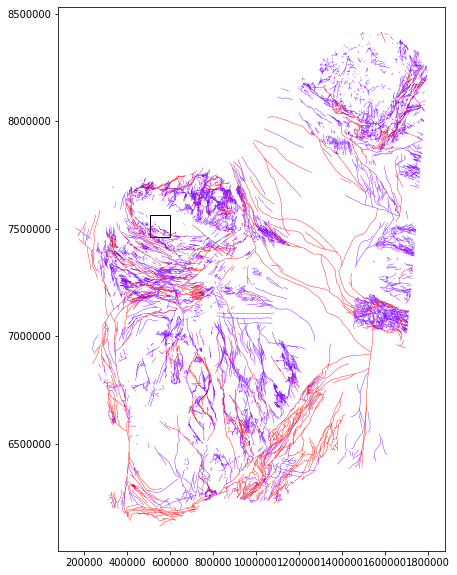

In [8]:
#bbox='-23,117,-22,118'
#lines=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology_structural_lines__DMIRS-013_&BBOX="+bbox+"&srs=EPSG:3857")
#print(lines)
#lines.plot(column='feature',figsize=(10,10),linewidth=0.2)
lines_ll=gpd.read_file("../test_data2/data/hams2_faults.shp")
#lines_ll = lines.to_crs('epsg:4326')
#print(geology.crs)
base2=lines_ll.plot(cmap='rainbow',column='FEATURE',figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [9]:
sub_lines = lines_ll[['geometry', 'OBJECTID','FEATURE']]

f= open('../test_data2/tmp/T1_500k_linearx.csv',"w+")
f.write("WKT\tOBJECTID\tFEATURE\n")

print(len(sub_lines)," polylines")

for i in range(0,len(sub_lines)):
    f.write("\""+str(sub_lines.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].OBJECTID)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].FEATURE)+"\"\n")
    
f.close()

15204  polylines


## Calculate topology

In [10]:
print(os.getcwd())
subprocess.run(['../m2m_cpp/map2model.exe', '../m2m_cpp/Parfile'])

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


CompletedProcess(args=['../m2m_cpp/map2model.exe', '../m2m_cpp/Parfile'], returncode=0)

## Simple network graph of the geology with legend

In [ ]:
G=nx.read_gml("../test_data2/graph/output/graph_strat.gml",label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Tology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

In [ ]:
from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/map2loop_after_topology.ipynb